In [7]:
import numpy as np
import matplotlib.pyplot as plt
import gsw
import xarray as xr
from glob import glob

Dynamics

$$ \vec{v} = \vec{u} + \vec{v}_s$$

with

$\vec{v_s} = (1 - \beta) \vec{g} \tau_p$

$\beta = \frac{3 \rho_f}{2 \rho_p + \rho_f}$

$\tau_p = \frac{a^2}{3 \beta \nu}$

In [29]:
def sinking_velocity(β, τ):
    g=9.81
    v_s = (1 - β)*g*τ
    
    return v_s

def beta(ρ_f, ρ_p):
    _β = 3*ρ_f/(2*ρ_p + ρ_f)
    
    return _β

def tau_p(a, β, ν):
    _τ = a**2/(3*β*ν)
    
    return _τ
    

 - Polypropylene(PP): 850–920 kg/m3
 - Polyethylene (PE): 890–980 kg/m3
 - Polystyrene (PS): 1040 kg/m3 (excluding its foamed version)
 - Polyesters (PEST): 1100– 1400 kg/m3
 - Polyamide (PA): 1120–1150 kg/m3
 - Acrylic: of 1180 kg/m3 

### PP

In [30]:
100**3*1.38/1000

1380.0

In [37]:
ρ_sea = 1035
ρ_PE = 1380
ν = 1e-6

diametres = np.linspace(1, 100000, 1000)*1e-9

In [38]:
beta_PE = beta(ρ_sea, ρ_PE)

In [39]:
tau_PE = tau_p(diametres, beta_PE, ν)

In [40]:
vs_PE = sinking_velocity(beta_PE, tau_PE)

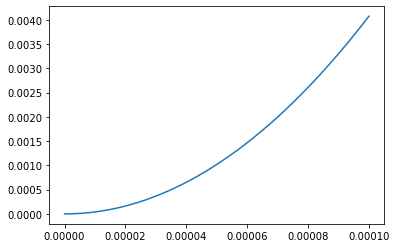

In [41]:
plt.plot(diametres, tau_PE)

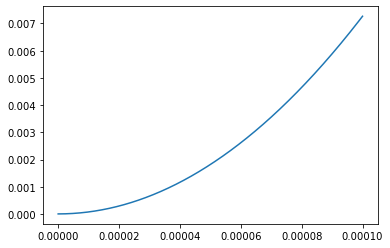

In [42]:
plt.plot(diametres, vs_PE)

## GSW density analysis

Basically the MOi dataset has data on Practical Salinity and Potential Temperature, but to compute the desnity of seawater with TEOS10, you need to have Absolute Salinity and Conservative Temperature. 

So the question is what happens if you don't convert the Practical Salinity and Potential Temperature, and direclty use the with the TEOS?

In [18]:
data_path = '/storage/shared/oceanparcels/input_data/MOi/2019/'
mesh_mask = '/storage/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/mesh_hgr.nc'

tfiles = sorted(glob(data_path + 'psy4v3r1-daily_T_2019-12*.nc'))    
sfiles = sorted(glob(data_path + 'psy4v3r1-daily_S_2019-12*.nc'))

In [21]:
pot_temp = xr.load_dataset(tfiles[0])
PS = xr.load_dataset(sfiles[0])

In [23]:
depth = PS['deptht']

Pick the sampling position for this comparison

In [56]:
lon_sample = 6.287
lon_idx = 3520
lat_sample = -32.171
lat_idx = 1086

In [52]:
lat_min = np.abs(PS['nav_lat'][:,0] - lat_sample)
np.where(lat_min == np.min(lat_min))

(array([1086]),)

In [55]:
lon_min = np.abs(PS['nav_lon'][0,:] - lon_sample)
np.where(lon_min == np.min(lon_min))

(array([3520]),)

In [65]:
PS_sampling = PS['vosaline'][:, lat_idx, lon_idx]

In [68]:
pt_sampling = pot_temp['votemper'][:, lat_idx, lon_idx]

In [40]:
np.where(lat_min == np.min(lat_min))

(array([1914]), array([3059]))

### TEOS10 correct procedure

In [31]:
pressure = gsw.p_from_z(-depth, lat_sample)

In [67]:
SA_sampling = gsw.SA_from_SP(PS_sampling, pressure, lon_sample, lat_sample)

In [70]:
CT_sampling = gsw.CT_from_pt(SA_sampling, pt_sampling)

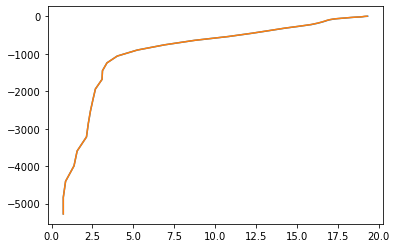

In [73]:
plt.plot(pt_sampling, -depth)
plt.plot(CT_sampling, -depth)

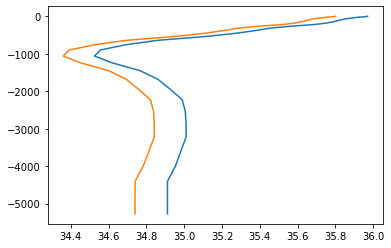

In [75]:
plt.plot(SA_sampling, -depth)
plt.plot(PS_sampling, -depth)

In [77]:
rho_SACT = gsw.density.rho(SA_sampling, CT_sampling, pressure)

In [78]:
rho_SPPT = gsw.density.rho(PS_sampling, pot_temp_sampling, pressure)

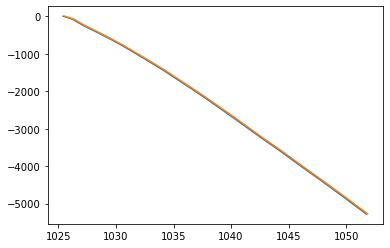

In [79]:
plt.plot(rho_SPPT, -depth)
plt.plot(rho_SACT, -depth)

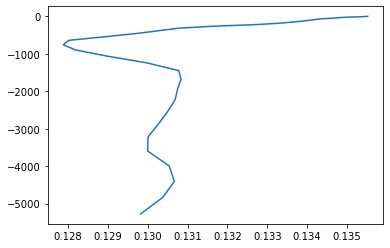

In [81]:
plt.plot(abs(rho_SPPT- rho_SACT), -depth)
# plt.plot(rho_SACT, -depth)